# Feature Engineering

### Setup & Loading Current Results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import sys
sys.path.append('../')

from src.preprocessing import preprocess_data

# Load data and preprocess
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train_processed, test_processed, y_log, train_ids, test_ids = preprocess_data(
    train, test, remove_outliers_flag=True
)

print("=" * 60)
print("BASELINE MODEL (from 03_modeling.ipynb)")
print("=" * 60)
print("Ridge Regression Validation RMSE: 0.1527")
print("R² Score: 0.8617")
print("=" * 60)
print("\nGoal: Improving Baseline with Feature Engineering!")
print("=" * 60)

Start Preprocessing...
Deleted: 2 Outliers

1. Handeling Missing Values...
Missing Values handeled. Remaining NAs: 0
Missing Values handeled. Remaining NAs: 0

2. Encoding Ordinal Features...

Preprocessing Done!
Training Shape: (1458, 79)
Test Shape: (1459, 79)
BASELINE MODEL (aus 03_modeling.ipynb)
Ridge Regression Validation RMSE: 0.1527
R² Score: 0.8617

Goal: Improving Baseline with Feature Engineering!


### Feature Engineering

In [2]:
def create_additional_features(df):
    """
    Create new features from existing
    """
    df = df.copy()
    
    print("Create new Features...")
    
    # 1. Total Square Footage
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    # 2. Total Bathrooms
    df['TotalBath'] = (df['FullBath'] + 
                       0.5 * df['HalfBath'] + 
                       df['BsmtFullBath'] + 
                       0.5 * df['BsmtHalfBath'])
    
    # 3. Total Porch SF
    df['TotalPorchSF'] = (df['OpenPorchSF'] + 
                          df['EnclosedPorch'] + 
                          df['3SsnPorch'] + 
                          df['ScreenPorch'])
    
    # 4. House Age & Remodel Age
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    
    # 5. Is Remodeled
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
    
    # 6. Quality * Square Footage Interactions
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    
    # 7. Binary Features (Has/Doesn't Have)
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    # 8. Quality Scores (combined quality features)
    df['TotalQuality'] = df['OverallQual'] + df['OverallCond']
    
    # 9. Lot Area per Living Area
    df['LotArea_per_GrLivArea'] = df['LotArea'] / (df['GrLivArea'] + 1)
    
    # 10. Garage Score
    if 'GarageQual' in df.columns and 'GarageCond' in df.columns:
        df['GarageScore'] = df['GarageQual'] + df['GarageCond']
    
    # 11. Kitchen per Room Ratio
    df['KitchenPerRoom'] = df['KitchenAbvGr'] / (df['TotRmsAbvGrd'] + 1)
    
    print(f"New Features created! New Shape: {df.shape}")
    
    return df


# Create features
train_with_features = create_additional_features(train_processed)
test_with_features = create_additional_features(test_processed)

print(f"\nbefore: {train_processed.shape}")
print(f"after: {train_with_features.shape}")
print(f"New Features: {train_with_features.shape[1] - train_processed.shape[1]}")

Create new Features...
New Features created! New Shape: (1458, 96)
Create new Features...
New Features created! New Shape: (1459, 96)

before: (1458, 79)
after: (1458, 96)
New Features: 17


### One-Hot Encoding

In [3]:
# Encode categorical features
categorical_features = train_with_features.select_dtypes(include=['object']).columns

train_encoded = pd.get_dummies(train_with_features, columns=categorical_features, drop_first=True)
test_encoded = pd.get_dummies(test_with_features, columns=categorical_features, drop_first=True)

# Ensure same columns
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

print(f"Final Training Shape: {train_encoded.shape}")
print(f"Final Test Shape: {test_encoded.shape}")

Final Training Shape: (1458, 228)
Final Test Shape: (1459, 228)


C:\Users\rapha\AppData\Local\Temp\ipykernel_23348\2022486112.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = train_with_features.select_dtypes(include=['object']).columns


### Train/Val Split

In [4]:
# Split for evaluation
X_train, X_val, y_train, y_val = train_test_split(
    train_encoded, y_log, test_size=0.2, random_state=42
)

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")

Training Set: (1166, 228)
Validation Set: (292, 228)


### Ridge With New Features

In [5]:
# Ridge Regression with new Features
alphas = [0.1, 1, 5, 10, 50, 100, 500, 1000]
ridge_fe = RidgeCV(alphas=alphas, cv=5)
ridge_fe.fit(X_train, y_train)

y_val_pred_fe = ridge_fe.predict(X_val)
val_rmse_fe = np.sqrt(mean_squared_error(y_val, y_val_pred_fe))
r2_fe = r2_score(y_val, y_val_pred_fe)

print("=" * 60)
print("RIDGE REGRESSION WITH FEATURE ENGINEERING")
print("=" * 60)
print(f"Best Alpha: {ridge_fe.alpha_}")
print(f"Validation RMSE: {val_rmse_fe:.4f}")
print(f"R² Score: {r2_fe:.4f}")
print("=" * 60)

# comparison with baseline
baseline_rmse = 0.1527
improvement = ((baseline_rmse - val_rmse_fe) / baseline_rmse) * 100

print(f"\nCOMPARISON:")
print(f"Baseline RMSE:          {baseline_rmse:.4f}")
print(f"With Feature Engineering: {val_rmse_fe:.4f}")
print(f"Improvement:            {improvement:+.2f}%")
print("=" * 60)

RIDGE REGRESSION WITH FEATURE ENGINEERING
Best Alpha: 10.0
Validation RMSE: 0.1439
R² Score: 0.8772

COMPARISON:
Baseline RMSE:          0.1527
With Feature Engineering: 0.1439
Improvement:            +5.78%


### Feature Importance Analysis


Top 20 most important Features:
                  Feature  Coefficient
109  Neighborhood_StoneBr     0.092404
93   Neighborhood_Crawfor     0.083126
103  Neighborhood_NridgHt     0.080036
202        Functional_Typ     0.065969
72            Street_Pave     0.059714
220          SaleType_New     0.059094
152   Exterior1st_BrkFace     0.058855
3             OverallQual     0.056514
192          CentralAir_Y     0.052888
149      RoofMatl_WdShngl     0.052716
95   Neighborhood_Gilbert     0.052708
113       Condition1_Norm     0.052558
90   Neighborhood_BrkSide     0.052428
70            MSZoning_RL     0.051781
226  SaleCondition_Normal     0.049253
94   Neighborhood_Edwards     0.047256
36             GarageCars     0.046971
64           TotalQuality     0.046253
97   Neighborhood_MeadowV     0.046069
62                HasBsmt     0.045239


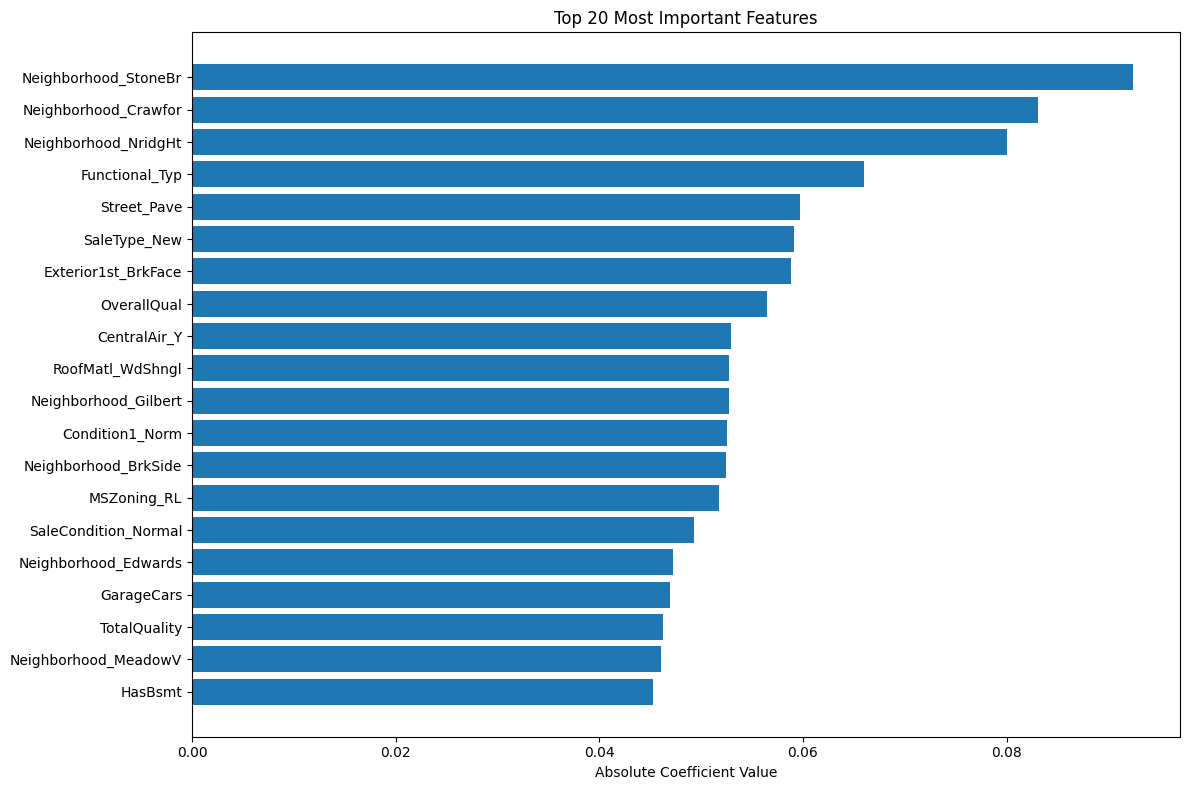

In [6]:
# identify most important features
feature_importance = pd.DataFrame({
    'Feature': train_encoded.columns,
    'Coefficient': np.abs(ridge_fe.coef_)
}).sort_values('Coefficient', ascending=False)

print("\nTop 20 most important Features:")
print(feature_importance.head(20))

# Visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['Coefficient'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Predictions & New Submission

In [7]:
# Train on all data
ridge_fe.fit(train_encoded, y_log)

# Predictions
test_predictions_log_fe = ridge_fe.predict(test_encoded)
test_predictions_fe = np.expm1(test_predictions_log_fe)

# Create submission
submission_fe = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions_fe
})

submission_fe.to_csv('../data/submission_feature_engineering.csv', index=False)

print("Submission with Feature Engineering saved!")
print(f"\nFile: submission_feature_engineering.csv")
print(submission_fe.head())

Submission with Feature Engineering saved!

File: submission_feature_engineering.csv
     Id      SalePrice
0  1461  112918.346909
1  1462  146074.169948
2  1463  168840.201487
3  1464  188075.647761
4  1465  192987.382772


### Comparison


RESULT SUMMARY
                    Notebook                       Model  Validation RMSE  R² Score  Features
           03_modeling.ipynb            Ridge (Baseline)         0.152700  0.861700       211
04_feature_engineering.ipynb Ridge + Feature Engineering         0.143879  0.877218       228


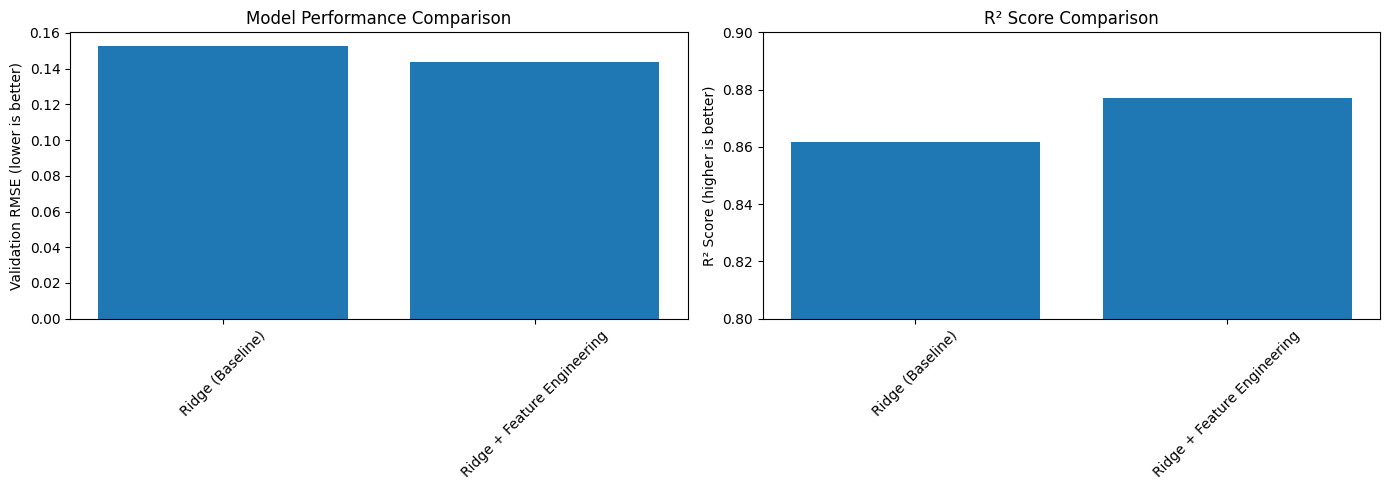

In [8]:
# Overview of all results
results_comparison = pd.DataFrame({
    'Notebook': [
        '03_modeling.ipynb',
        '04_feature_engineering.ipynb'
    ],
    'Model': [
        'Ridge (Baseline)',
        'Ridge + Feature Engineering'
    ],
    'Validation RMSE': [
        0.1527,
        val_rmse_fe
    ],
    'R² Score': [
        0.8617,
        r2_fe
    ],
    'Features': [
        211,
        train_encoded.shape[1]
    ]
})

print("\n" + "=" * 80)
print("RESULT SUMMARY")
print("=" * 80)
print(results_comparison.to_string(index=False))
print("=" * 80)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
axes[0].bar(results_comparison['Model'], results_comparison['Validation RMSE'])
axes[0].set_ylabel('Validation RMSE (lower is better)')
axes[0].set_title('Model Performance Comparison')
axes[0].tick_params(axis='x', rotation=45)

# R² Score comparison
axes[1].bar(results_comparison['Model'], results_comparison['R² Score'])
axes[1].set_ylabel('R² Score (higher is better)')
axes[1].set_title('R² Score Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim([0.8, 0.9])

plt.tight_layout()
plt.show()